In [1]:
from galactic import GalacticDataset

Let's use a variant of the Alpaca fine-tuning dataset, with responses generated by GPT-4. We'll take 10,000 examples. As it turns out, there's lots of redundant instructions even in this small subset--Galactic will help us find and pare it down.

In [2]:
ds = GalacticDataset.from_hugging_face(
    "vicgalle/alpaca-gpt4",
    split="train"
).select(range(10000))

We'll embed the "instruction" field, as we want to organize/cluster the data by the sort of queries the user is asking of the model. To save time, we'll use the OpenAI API for embeddings, but if you choose `backend='cpu'`, you can do this right on your computer too!

In [3]:
# have to do this to run async routines (like the openai api) in jupyter
import nest_asyncio
nest_asyncio.apply()

ds.set_openai_key(open("/Users/ben/Desktop/oai_api_key.txt").read().strip())
ds.set_rate_limits(
    max_requests_per_minute=3000,
    max_tokens_per_minute=500_000
)
ds.get_embeddings(input_field="instruction", backend="openai")

Parameter 'function'=<function get_embeddings.<locals>._embed_batch at 0x1367757e0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

INFO: Parallel processing complete.
INFO: Requests left: 7000
INFO: Parallel processing complete.
INFO: Requests left: 4000
INFO: Parallel processing complete.
INFO: Requests left: 1000
INFO: Parallel processing complete.
INFO: Requests left: 0
INFO: Created embeddings on field 'instruction', stored in '__embedding'.


                                         instruction  \
0               Give three tips for staying healthy.   
1                 What are the three primary colors?   
2                 Describe the structure of an atom.   
3                   How can we reduce air pollution?   
4  Describe a time when you had to make a difficu...   
5                          Identify the odd one out.   
6  Explain why the following fraction is equivale...   
7  Write a short story in third person narration ...   
8                       Render a 3D model of a house   
9  Evaluate this sentence for spelling and gramma...   

                                          input  \
0                                                 
1                                                 
2                                                 
3                                                 
4                                                 
5                  Twitter, Instagram, Telegram   
6                         

Alright! Now that we have embeddings, we can cluster the dataset. Sometimes, clustering can be more effective if we first reduce the dimensionality of the embeddings. We'll use PCA to reduce the dimensionality from 1536 to 50.

In [4]:
ds.reduce_embedding_dim(
    n_dims=50,
    method="pca"
)

INFO: Reduced embeddings to 50 dimensions using pca. New embeddings stored in column '__embedding_pca_50'


                                         instruction  \
0               Give three tips for staying healthy.   
1                 What are the three primary colors?   
2                 Describe the structure of an atom.   
3                   How can we reduce air pollution?   
4  Describe a time when you had to make a difficu...   
5                          Identify the odd one out.   
6  Explain why the following fraction is equivale...   
7  Write a short story in third person narration ...   
8                       Render a 3D model of a house   
9  Evaluate this sentence for spelling and gramma...   

                                          input  \
0                                                 
1                                                 
2                                                 
3                                                 
4                                                 
5                  Twitter, Instagram, Telegram   
6                         

Now that we have new embeddings in the `__embedding_pca_50` column, these can be used to cluster the dataset. We'll use the `BisectingKMeans` algorithm, which is a variant of K-Means that tends to produce more evenly-sized clusters (because at each step, it forms new clusters by bisecting an existing cluster). Galactic also supports vanilla K-Means and HDBSCAN (which is recommended if you used UMAP before clustering).

In order to use the right column (rather than the default `__embedding` column), we have to pass the embedding field as an argument.

In [5]:
ds.cluster(
    n_clusters=30,
    method="bisecting_kmeans",
    embedding_field="__embedding_pca_50"
)

Let's get some basic information about these clusters. Note that we have to pass the embedding field used for clustering, otherwise the `cluster_info` function will use the default `__embedding` column to find nearest neighbors, which will fail because it's 1536 dimensions, while cluster centers are 50.

In [6]:
ds.get_cluster_info(embedding_field="__embedding_pca_50", context_fields=["instruction"])

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Cluster 24 (272 items)
### Example 1
	- instruction: Name the five main food groups.
### Example 2
	- instruction: List five healthy eating habits.
### Example 3
	- instruction: List 5 things that can be bought at a grocery store
Cluster 23 (241 items)
### Example 1
	- instruction: Name five countries with the most number of UNESCO World Heritage sites.
### Example 2
	- instruction: Name the 5 major countries in South America.
### Example 3
	- instruction: Name three famous European landmarks
Cluster 21 (483 items)
### Example 1
	- instruction: Explain the theory of gravity.
### Example 2
	- instruction: Explain the concept of entropy in thermodynamics.
### Example 3
	- instruction: Explain what the big bang theory is.
Cluster 20 (447 items)
### Example 1
	- instruction: Name two environmental issues caused by global warming.
### Example 2
	- instruction: What do you think is the major cause of climate change?
### Example 3
	- instruction: What is a common impact of climate change?
Clu

[{'cluster_id': 24,
  'cluster_size': 272,
  'examples': [{'instruction': 'Name the five main food groups.'},
   {'instruction': 'List five healthy eating habits.'},
   {'instruction': 'List 5 things that can be bought at a grocery store'}]},
 {'cluster_id': 23,
  'cluster_size': 241,
  'examples': [{'instruction': 'Name five countries with the most number of UNESCO World Heritage sites.'},
   {'instruction': 'Name the 5 major countries in South America.'},
   {'instruction': 'Name three famous European landmarks'}]},
 {'cluster_id': 21,
  'cluster_size': 483,
  'examples': [{'instruction': 'Explain the theory of gravity.'},
   {'instruction': 'Explain the concept of entropy in thermodynamics.'},
   {'instruction': 'Explain what the big bang theory is.'}]},
 {'cluster_id': 20,
  'cluster_size': 447,
  'examples': [{'instruction': 'Name two environmental issues caused by global warming.'},
   {'instruction': 'What do you think is the major cause of climate change?'},
   {'instruction': 

This gives us some color on what's going on in each cluster based on its central examples, but it's not easy to read, and it's not exhaustive (a few examples from each cluster may or may not be representative). This also isn't super-scalable to large numbers of clusters or big clusters. Something more scalable: using LLMs to help label clusters. Let's try that!

In [7]:
ds.ai_label_clusters(
    new_column="cluster_label",
    context_fields=["instruction"],
    cluster_field="__cluster",
    embedding_field = "__embedding_pca_50", # it's important to use the same embedding used to create the cluster. doesn't matter if using "random" selection
    n_examples=25,
    selection="random",
    prompt=None,  # use the default prompt
)

INFO: Splitting dataset into clusters... (this might take a bit).


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

  0%|          | 0/30 [00:00<?, ?it/s]

INFO: Parallel processing complete.


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

                                         instruction  \
0               Give three tips for staying healthy.   
1                 What are the three primary colors?   
2                 Describe the structure of an atom.   
3                   How can we reduce air pollution?   
4  Describe a time when you had to make a difficu...   
5                          Identify the odd one out.   
6  Explain why the following fraction is equivale...   
7  Write a short story in third person narration ...   
8                       Render a 3D model of a house   
9  Evaluate this sentence for spelling and gramma...   

                                          input  \
0                                                 
1                                                 
2                                                 
3                                                 
4                                                 
5                  Twitter, Instagram, Telegram   
6                         

We can now see that some clusters have clear themes, while others don't (the default prompt instructs the model to say there's no clear theme if there isn't one).

In [8]:
from collections import Counter
Counter(ds["cluster_label"])

Counter({'No shared topic or theme.': 792,
         'No shared topic or theme': 719,
         'Language instruction and editing.': 469,
         'Data Manipulation and Transformation': 444,
         'Language and Linguistic Skills': 429,
         'Creative Writing Prompts.': 426,
         'Mathematics and problem-solving techniques': 422,
         'Instruction-based tasks for writing and summarizing content.': 418,
         'Algorithm design and implementation.': 409,
         'Artificial Intelligence and its Applications': 403,
         'Mathematics and Measurement': 390,
         'Creating or developing various products, strategies, and designs.': 378,
         'Instructions for sentence construction or modification': 362,
         'Self-improvement and practical advice.': 361,
         'Language analysis and classification.': 325,
         'Storytelling and narrative creation.': 311,
         'Computer Science and Technology': 300,
         'Workplace Skills and Tasks': 277,
       

Another thing we could notice from looking at central points in each cluster is that there's a lot of redundancy! We can use semantic deduplication to remove examples that have the same meaning, to leave us with a smaller, diverse dataset. Let's give that a try. We'll target retaining 50% of the data (this will be tuned on a few clusters, so it won't be perfect).

In [9]:
ds.semdedup(
    target_retention=0.5,
    embedding_field="__embedding_pca_50",
    cluster_field="__cluster",
    num_tuning_clusters=6,
    dedup_strategy="random",
    inplace=True,
)

It's semdedup time! Using embedding field __embedding_pca_50


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

INFO: Tuning threshold on 6 clusters...


Minimum similarity: -0.04383985328651988 Maximum similarity: 0.21441115565225433


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.085, Retention: 0.237


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.15, Retention: 0.908


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.118, Retention: 0.678


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.101, Retention: 0.463


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.109, Retention: 0.573


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.105, Retention: 0.528


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.103, Retention: 0.49


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.104, Retention: 0.501
Minimum similarity: -0.04265071026143381 Maximum similarity: 0.17356602807910726


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.065, Retention: 0.032


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.12, Retention: 0.834


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.092, Retention: 0.304


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.106, Retention: 0.593


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.099, Retention: 0.443


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.103, Retention: 0.486


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.104, Retention: 0.534


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.103, Retention: 0.502
Minimum similarity: -0.046135003255585456 Maximum similarity: 0.16686895800945767


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.06, Retention: 0.089


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.114, Retention: 0.957


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.087, Retention: 0.625


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.074, Retention: 0.337


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.08, Retention: 0.474


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.084, Retention: 0.559


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.082, Retention: 0.518


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.081, Retention: 0.495
Minimum similarity: -0.022474565591224942 Maximum similarity: 0.23251453631652752


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.105, Retention: 0.109


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.169, Retention: 0.864


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.137, Retention: 0.531


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.121, Retention: 0.298


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.129, Retention: 0.419


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.133, Retention: 0.462


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.135, Retention: 0.499
Minimum similarity: -0.030013773404159182 Maximum similarity: 0.19787873126854968


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.084, Retention: 0.16


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.141, Retention: 0.938


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.112, Retention: 0.585


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.098, Retention: 0.357


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.105, Retention: 0.483


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.109, Retention: 0.532


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.107, Retention: 0.505
Minimum similarity: -0.028893385088375134 Maximum similarity: 0.17721032608882523


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.074, Retention: 0.074


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.126, Retention: 0.931


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.1, Retention: 0.431


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.113, Retention: 0.787


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.106, Retention: 0.617


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.103, Retention: 0.511


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.102, Retention: 0.457


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.102, Retention: 0.484


INFO: getting duplicates. embedding field is __embedding_pca_50


Threshold: 0.103, Retention: 0.5


INFO: Threshold: 0.11
INFO: getting duplicates. embedding field is __embedding_pca_50
INFO: Cluster 24 has 169 duplicates (62.1%).

INFO: getting duplicates. embedding field is __embedding_pca_50
INFO: Cluster 23 has 129 duplicates (53.5%).

INFO: getting duplicates. embedding field is __embedding_pca_50
INFO: Cluster 21 has 38 duplicates (7.9%).

INFO: getting duplicates. embedding field is __embedding_pca_50
INFO: Cluster 20 has 211 duplicates (47.2%).

INFO: getting duplicates. embedding field is __embedding_pca_50
INFO: Cluster 1 has 30 duplicates (10.9%).

INFO: getting duplicates. embedding field is __embedding_pca_50
INFO: Cluster 25 has 165 duplicates (64.7%).

INFO: getting duplicates. embedding field is __embedding_pca_50
INFO: Cluster 29 has 252 duplicates (64.6%).

INFO: getting duplicates. embedding field is __embedding_pca_50
INFO: Cluster 4 has 146 duplicates (46.9%).

INFO: getting duplicates. embedding field is __embedding_pca_50
INFO: Cluster 26 has 260 duplicates (58

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

INFO: Removed 4331 / 10000 items flagged as semantic near-duplicates (43.31%).


                                         instruction  \
0               Give three tips for staying healthy.   
1                 What are the three primary colors?   
2                 Describe the structure of an atom.   
3  Describe a time when you had to make a difficu...   
4                          Identify the odd one out.   
5  Explain why the following fraction is equivale...   
6  Write a short story in third person narration ...   
7                       Render a 3D model of a house   
8  Evaluate this sentence for spelling and gramma...   
9                         How did Julius Caesar die?   

                                          input  \
0                                                 
1                                                 
2                                                 
3                                                 
4                  Twitter, Instagram, Telegram   
5                                          4/16   
6                         

Next, let's take the data that remains, and make sure that everything we keep actually matches the cluster it was assigned to. That way, we can be confident that the clusters in the data are meaningful. Then, we may decide to keep clusters related to topics of interest, and discard ones that aren't.

In [15]:
ds = ds.map(
    lambda x: {"instruction_with_cluster": "Instruction: " + x["instruction"] + "\nLabel: " + x["cluster_label"]},
).ai_tagger(
    field="instruction_with_cluster",
    tags={"matches": "The instruction matches the label."},
    prompt = None,
    backend="openai",
    allow_not_sure = False,
)

INFO: Tagging with tag matches...


Map:   0%|          | 0/5669 [00:00<?, ? examples/s]

INFO: Example prompt for tag matches: Tag the provided text with the following tag:
  - matches: The instruction matches the label.
Answer True if the tag applies to the text, and False if it does not. 

---

Text: Instruction: Give three tips for staying healthy.
Label: No shared topic or theme

---

Does the tag apply?


  0%|          | 0/5669 [00:00<?, ?it/s]

ERROR: {'error': {'code': 503, 'message': 'Service Unavailable.', 'param': None, 'type': 'cf_service_unavailable'}}
ERROR: {'error': {'code': 503, 'message': 'Service Unavailable.', 'param': None, 'type': 'cf_service_unavailable'}}
ERROR: {'error': {'code': 503, 'message': 'Service Unavailable.', 'param': None, 'type': 'cf_service_unavailable'}}
ERROR: {'error': {'code': 503, 'message': 'Service Unavailable.', 'param': None, 'type': 'cf_service_unavailable'}}
ERROR: {'error': {'code': 503, 'message': 'Service Unavailable.', 'param': None, 'type': 'cf_service_unavailable'}}
ERROR: {'error': {'code': 503, 'message': 'Service Unavailable.', 'param': None, 'type': 'cf_service_unavailable'}}
ERROR: {'error': {'code': 503, 'message': 'Service Unavailable.', 'param': None, 'type': 'cf_service_unavailable'}}
ERROR: {'error': {'code': 503, 'message': 'Service Unavailable.', 'param': None, 'type': 'cf_service_unavailable'}}
ERROR: {'error': {'code': 503, 'message': 'Service Unavailable.', 'param

In [18]:
ds = ds.filter(
    lambda x: x["__ai_tag__matches"] == "True"
)
len(ds)

Counter({'True': 2341})


Filter:   0%|          | 0/2341 [00:00<?, ? examples/s]

2341

Now we've deduplicated and made sure that the only remaining datapoints truly match their cluster. Let's look at the data we have left! In order to reasonably visualize high-dimensional data, we have to reduce it to 2 or 3 dimensions. We'll use UMAP for this, because it's designed to preserve the structure of the data manifold. We'll see how well our clusters are preserved in the 2-D embedding space.

In [20]:
ds.reduce_embedding_dim(
    n_dims=2,
    new_column="__embedding_umap",
    embedding_field="__embedding_pca_50",
)

Flattening the indices:   0%|          | 0/2341 [00:00<?, ? examples/s]

INFO: Reduced embeddings to 2 dimensions using pca. New embeddings stored in column '__embedding_umap'


                                         instruction  \
0                          Identify the odd one out.   
1  Explain why the following fraction is equivale...   
2  Write a short story in third person narration ...   
3  Evaluate this sentence for spelling and gramma...   
4         Discuss the causes of the Great Depression   
5    Describe the function of a computer motherboard   
6  Generate three verbs that mean the same as "to...   
7  Compare and contrast the Cuban Missile Crisis ...   
8  Identify the lines of longitude that divides N...   
9  Generate a list of adjectives that describe a ...   

                                          input  \
0                  Twitter, Instagram, Telegram   
1                                          4/16   
2                                                 
3  He finnished his meal and left the resturant   
4                                                 
5                                                 
6                         

INFO: Saved plot to umap.png


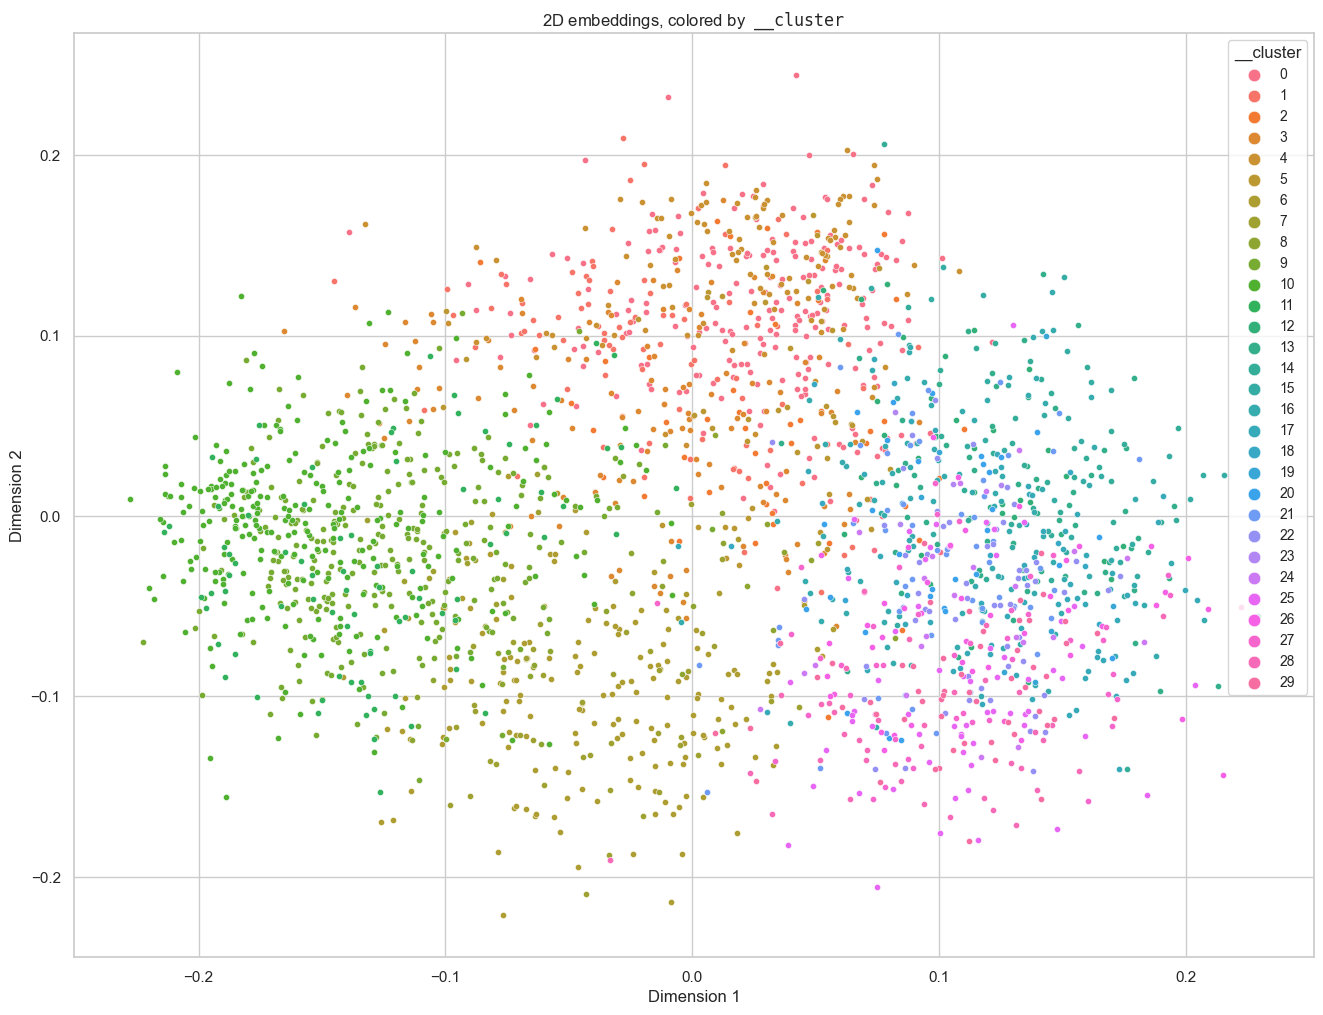

In [22]:
ds.plot_embeddings(
    embedding_field="__embedding_umap",
    color_by="__cluster",
    width=16,
    height=12,
    save_path="umap.png",
    dot_size=20
)

We can see that clusters certainly aren't perfectly separated in this 2-D embedding space, but you can definitely notice some boundaries. Getting a "good" clustering requires iterating, inspecting your data, and even trying out your downstream task to see how well deduplication is working. (For example, we might consider doing UMAP -> HDBSCAN instead of PCA -> K-means). Galactic provides the tools so you can try all these out with no boilerplate! For now, we'll save this dataset and call it a day.

In [29]:
ds = ds.select_columns(["instruction", "input", "output"])
ds.save("alpaca_cleaned.csv", overwrite=True)

Creating CSV from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]